In [13]:
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib import style
style.use('ggplot')
%matplotlib notebook
import os
os.chdir('/Users/pipegalera/Documents/GitHub/side_projects/finance')

### Import data

In [22]:
start = dt.datetime(2000, 1, 1)
end = dt.now()

data = web.get_data_yahoo('TSLA', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,425.470001,412.690002,418.359985,425.250000,8054700,425.250000
2019-12-26,433.480011,426.350006,427.910004,430.940002,10633900,430.940002
2019-12-27,435.309998,426.109985,435.000000,430.380005,9945700,430.380005
2019-12-30,429.000000,409.260010,428.790009,414.700012,12586400,414.700012
2019-12-31,421.290009,402.079987,405.000000,418.329987,10285700,418.329987


### Creating a column with rolling average

In [3]:
data['rolling'] = data['Adj Close'].rolling(window = 100, min_periods = 0).mean()

### Plot data

/Users/pipegalera/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


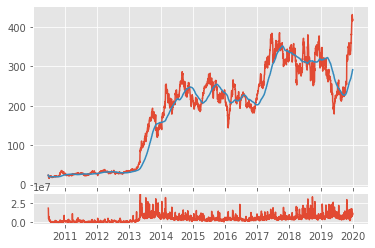

In [4]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 5, colspan = 1, sharex = ax1)

ax1.plot(data.index, data['Adj Close'])
ax1.plot(data.index, data['rolling'])
ax2.plot(data.index, data['Volume'])

### Creating an 'OHLC' Resamplaing

We don't HAVE to resample the volume data, but we should, since it would be too granular compared to our 10D pricing data. 

In [5]:
data_ohlc = data['Adj Close'].resample('10D').ohlc()
data_volume = data['Volume'].resample('10D').sum()

In [6]:
print(data_ohlc)

                  open        high         low       close
Date                                                      
2010-06-29   23.889999   23.889999   15.800000   17.459999
2010-07-09   17.400000   20.639999   17.049999   20.639999
2010-07-19   21.910000   21.910000   20.219999   20.719999
2010-07-29   20.350000   21.950001   19.590000   19.590000
2010-08-08   19.600000   19.600000   17.600000   19.150000
...                ...         ...         ...         ...
2019-11-19  359.519989  359.519989  328.920013  331.290009
2019-11-29  329.940002  336.200012  329.940002  335.890015
2019-12-09  339.529999  393.149994  339.529999  393.149994
2019-12-19  404.040009  430.940002  404.040009  430.380005
2019-12-29  414.700012  418.329987  414.700012  418.329987

[348 rows x 4 columns]


### Plot using matplotlib.finance 

First, we have to convert the dates (index) to a matplotlib dates format.

In [7]:
data_ohlc.reset_index(inplace = True)
data_ohlc['Date'] = data_ohlc['Date'].map(mdates.date2num)

In the first graph we use the candlestick, while in the second the volume

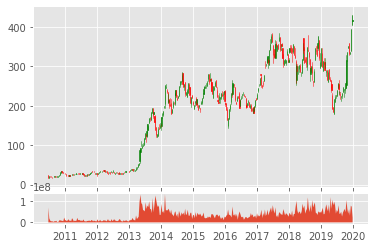

In [8]:
fig = plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 5, colspan = 1, sharex = ax1)

ax1.xaxis_date()
candlestick_ohlc(ax1, data_ohlc.values, width = 2, colorup = 'g', colordown='r')
ax2.fill_between(data_volume.index.map(mdates.date2num), data_volume.values, 0)
 

# Automating getting the S&P 500 list

In [19]:
import bs4 as bs
import pickle 
import requests

In [15]:

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.replace('.', '-')
        ticker = ticker[:-1]
        tickers.append(ticker)
    
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
    
    return tickers

#save_sp500_tickers()

# Getting all company pricing data in the S&P 500

In [24]:
def get_data_from_yahoo(reload_sp500 = False):
    # Get the tickers from the previous function
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', "rb") as f:
            tickers = pickle.load(f)
            
    # If the file does not exist create it
    if not os.path.exists('raw_data/stocks_dfs'):
        os.makedirs('raw_data/stocks_dfs') 
        
    # Set the datetime you want to take the stocks
    start = dt.datetime(2000,1,1)
    end = dt.datetime.now()
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('raw_data/stocks_dfs/{}.csv'.format(ticker)):
            df = web.get_data_yahoo(ticker, start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            df.to_csv('raw_data/stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

        
#get_data_from_yahoo()

MMM
Already have MMM
ABT
Already have ABT
ABBV
Already have ABBV
ABMD
Already have ABMD
ACN
Already have ACN
ATVI
Already have ATVI
ADBE
Already have ADBE
AMD
Already have AMD
AAP
Already have AAP
AES
Already have AES
AFL
Already have AFL
A
Already have A
APD
Already have APD
AKAM
Already have AKAM
ALK
Already have ALK
ALB
Already have ALB
ARE
Already have ARE
ALXN
Already have ALXN
ALGN
Already have ALGN
ALLE
Already have ALLE
AGN
Already have AGN
ADS
Already have ADS
LNT
Already have LNT
ALL
Already have ALL
GOOGL
Already have GOOGL
GOOG
Already have GOOG
MO
Already have MO
AMZN
Already have AMZN
AMCR
Already have AMCR
AEE
Already have AEE
AAL
Already have AAL
AEP
Already have AEP
AXP
Already have AXP
AIG
Already have AIG
AMT
Already have AMT
AWK
Already have AWK
AMP
Already have AMP
ABC
Already have ABC
AME
Already have AME
AMGN
Already have AMGN
APH
Already have APH
ADI
Already have ADI
ANSS
Already have ANSS
ANTM
Already have ANTM
AON
Already have AON
AOS
Already have AOS
APA
Alre

# Combining S&P 500 into one DataFrame

In [40]:
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('raw_data/stocks_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'Close', 'High', 'Low', 'Volume'], axis = 1, inplace = True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how = 'outer')
            
        if count % 10 == 0:
            print(count)

        main_df.to_csv('raw_data/sp500_joined_closes.csv')
        print(main_df.head())
    
compile_data()

0
                   MMM
Date                  
2019-06-10  163.848907
2019-06-11  164.452560
2019-06-12  164.549911
2019-06-13  164.394150
2019-06-14  162.291153
                   MMM        ABT
Date                             
2019-06-10  163.848907  79.965683
2019-06-11  164.452560  79.818092
2019-06-12  164.549911  80.634766
2019-06-13  164.394150  80.969315
2019-06-14  162.291153  80.900444
                   MMM        ABT       ABBV
Date                                        
2019-06-10  163.848907  79.965683  71.570518
2019-06-11  164.452560  79.818092  72.705223
2019-06-12  164.549911  80.634766  73.077278
2019-06-13  164.394150  80.969315  73.430702
2019-06-14  162.291153  80.900444  73.188889
                   MMM        ABT       ABBV        ABMD
Date                                                    
2019-06-10  163.848907  79.965683  71.570518  272.429993
2019-06-11  164.452560  79.818092  72.705223  262.029999
2019-06-12  164.549911  80.634766  73.077278  254.539993

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  \
Date                                                                  
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123   
2019-06-14  45.321922  274.279999  30.360001  151.196823  16.533634  

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3

                   MMM        ABT       ABBV        ABMD         ACN  \
Date                                                                   
2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
Date                                                                 ...   
2019-06-10  45.709373  280.339996  33.230000  152.910004  15.895121  ...   
2019-06-11  46.394871  275.989990  32.410000  151.565353  15.846747  ...   
2019-06-12  44.795387  276.839996  32.180000  149.941818  16.214376  ...   
2019-06-13  45.749115  276.299988  31.389999  150.011551  16.311123  ...   
2019-06-14  45.321922  274.279999  30.3